# RNA-protein correlations

Zoë Steier
3/27/29

* Dataset: SLN111-D1

## Imports and settings

In [1]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import anndata
import seaborn as sns

from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData, CsvDataset
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, UnsupervisedTrainer

from scipy.special import softmax
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

set_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load data

In [4]:
# Load anndata
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [5]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_111]
anndataset.obs["cell_types"] = pd.Categorical([ct.replace('\n', '') for ct in  anndataset.obs["cell_types"]])

# Organize and instantiate scVI dataset
hvg_111 = anndataset.var["hvg_encode"]

dataset = AnnDatasetFromAnnData(ad=anndataset[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"]
)
dataset.initialize_cell_measurement(protein_data_111)
dataset.gene_names = anndataset[:, hvg_111].var_names.values

[2020-03-27 08:49:41,171] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-27 08:49:41,174] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-27 08:49:41,237] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-27 08:49:41,300] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [6]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 9264 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'labels', 'batch_indices', 'protein_expression', 'local_vars', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

## Load and evaluate totalVI model

In [7]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    #n_batch=dataset.n_batches,
)

In [8]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [9]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/differential_expression/saved_models/111_d1.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4115, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [10]:
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

### Subset the data to exclude doublets before calculating correlations

In [11]:
# Load saved posterior anndata object
adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_111day1.h5ad")

In [12]:
# Subset clusters before calculating correlations
# Exclude doublets and low quality cells (uncorrelated genes would appear correlated with each other)

include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset.obs["leiden_subclusters"]
]

In [13]:
# Subset adata to exclude doublets
adata = adata[include_cells]

In [14]:
adata.X.shape

(8736, 4005)

### Generate posterior

In [18]:
# create posterior on subset of the data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset))[include_cells], type_class=TotalPosterior
)

# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25 # set to 2 to run faster
# Probability of background on logits scale, first dataset.nb_genes columns corresponds to ZI probability for genes
# py_mixing was previously px_dropout
# py_mixing = sigmoid(
#     full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
# )

# protein_foreground_prob = pd.DataFrame(
#     data=(1 - py_mixing), columns=dataset.protein_names
# )

# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True,
) # tranform batch puts all denoised samples into the same batch, here, choose WT
# input a list to average over all batches if give_mean = True

In [19]:
# Revised foreground
# take mean of sigmoid, not sigmoid of the mean
py_mixing = np.mean(sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=False)
), axis=-1)
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)

In [20]:
denoised_genes.shape

(8736, 4005)

## Generate correlations on full denoised dataset

### Calculate totalVI correlations

In [21]:
# Use this function to generate correlations:
# https://github.com/YosefLab/scVI/blob/totalVI_updates/scvi/inference/total_inference.py
# This calculates the pearson correlation

# Add transform_batch = 0 when calculating correlations from multiple batches


# Pearson no log
#corr_matrix = full_posterior.generate_feature_correlation_matrix() # pearson

# Pearson with log
corr_matrix = full_posterior.generate_feature_correlation_matrix(correlation_mode="pearson", 
                                                                  log_transform = True,
                                                                 rna_size_factor = 1e4)

In [22]:
corr_matrix.shape # 4005 genes + 110 proteins

(4115, 4115)

In [23]:
# Calculation spearman correlation as well (added on 1/8/20)

# Spearman no log
#corr_totalVI_spearman = full_posterior.generate_feature_correlation_matrix(correlation_mode = "spearman") # (2, 4119, 4119)

# Spearman with log
corr_totalVI_spearman = full_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", 
                                                                  log_transform = True,
                                                                 rna_size_factor = 1e4)

In [24]:
corr_totalVI_spearman.shape 
 # (2, 4119, 4119) # first return is correlation coefficient, second is p value

(2, 4115, 4115)

In [25]:
corr_totalVI_spearmanr = corr_totalVI_spearman[0, :, :]

In [26]:
corr_totalVI_spearmanr.shape

(4115, 4115)

### Calculate raw correlations

In [27]:
# Normalize RNA data by standard pipeline in scanpy

# Normalize for library size (adjust to 10,000 counts/cell)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log the data
sc.pp.log1p(adata)

# Save log(raw) as adata.raw
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [28]:
# Raw RNA data = dataset.X
# Raw protein data = dataset.protein_expression

# concatenate
# Truly raw data
#raw_data = np.concatenate((dataset.X, dataset.protein_expression), axis = 1) # concat genes, proteins

# Log raw data
raw_data = np.concatenate((adata.X, np.log1p(adata.obsm["protein_expression"])), axis = 1) # concat genes, proteins

raw_data.shape # (8736, 4115) cells x (genes + proteins)

(8736, 4115)

In [29]:
# Calculate raw correlations (Pearson)
corr_raw = np.corrcoef(raw_data, rowvar = False) # rowvar = False for cells x genes

In [30]:
corr_raw.shape

(4115, 4115)

In [31]:
# Calculate raw spearman correlation
corr_raw_spearman =  spearmanr(raw_data, axis = 0)

In [32]:
corr_raw_spearman[0].shape

(4115, 4115)

In [33]:
corr_raw_spearmanr = corr_raw_spearman[0] # the correlation array, [1] is the p value

## Identify RNA-protein pairs

In [34]:
# Find names of all genes and proteins

gene_protein_names = np.concatenate((dataset.gene_names, dataset.protein_names)) # all genes and proteins
gene_protein_names.shape # 4005 RNA + 110 proteins

(4115,)

In [35]:
protein_names = pd.read_csv(
    "/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT206_ADT111_matched.csv"
)
protein_to_rna_table = pd.read_csv(
    "/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT111_barcodes_RNA_20190717.csv"
)

In [36]:
# Subset on proteins included in this panel
subset_111 = protein_names["name_206"][~protein_names["name_111"].isnull()].values

# # Some genes encode multiple protein so it's ok to overwrite key in this case as it will be included downstream
protein_111_names = protein_names["name_111"][~protein_names["name_111"].isnull()].values
RNA_names = []
for p1, p2 in zip(protein_111_names, subset_111):
    ind = np.where(protein_to_rna_table["name"] == p1)[0]    
    RNA_names.append(str(protein_to_rna_table.loc[ind, "RNA"].values[0])) # remove the .upper()
    
rna_protein = pd.concat([pd.Series(RNA_names, name = "RNA_name"), pd.Series(subset_111, name = "protein_name")], axis = 1)

In [37]:
rna_protein

,RNA_name,protein_name
0,Icam2,ADT_CD102_A0104
1,Itgae,ADT_CD103_A0201
2,Vcam1,ADT_CD106_A0226
3,Csf1r,ADT_CD115(CSF-1R)_A0105
4,Kit,ADT_CD117(c-Kit)_A0012
...,...,...
108,Xcr1,ADT_XCR1_A0568
109,P2ry12,ADT_anti-P2RY12_A0415
110,Itgb7,ADT_integrinb7_A0214
111,Ptprc,HTO_B6_LN_r4_206_A0301


In [38]:
# Find indices of gene protein pairs in this dataset
gene_protein_pairs = np.array([gene in np.concatenate((rna_protein["RNA_name"].values, rna_protein["protein_name"].values)) for gene in gene_protein_names])

In [39]:
np.sum(gene_protein_pairs) # 208 = 98 genes + 110 proteins (not unique genes for each protein)
# Be aware that there is a NAN for H-2KbboundtoSIINFEKL

208

In [40]:
# Names of genes/proteins in pairs
rna_prot_pairs_names = gene_protein_names[gene_protein_pairs]

### Subset correlations to RNA-protein pairs

In [41]:
# Subset correlations for RNA-protein pairs
# totalVI pearson
corr_totalvi_rna_prot = corr_matrix[:, gene_protein_pairs]
corr_totalvi_rna_prot = corr_totalvi_rna_prot[gene_protein_pairs, :]

# raw pearson
corr_raw_rna_prot = corr_raw[:, gene_protein_pairs]
corr_raw_rna_prot = corr_raw_rna_prot[gene_protein_pairs, :]

In [42]:
# Subset like above for spearman
# totalVI spearman
corr_totalVI_spearman_rna_prot = corr_totalVI_spearmanr[:, gene_protein_pairs]
corr_totalVI_spearman_rna_prot = corr_totalVI_spearman_rna_prot[gene_protein_pairs, :]

# raw spearman
corr_raw_spearman_rna_prot = corr_raw_spearmanr[:, gene_protein_pairs]
corr_raw_spearman_rna_prot = corr_raw_spearman_rna_prot[gene_protein_pairs, :]

In [43]:
# Create dataframes for raw and totalVI denoised 
# corr_totalvi_rna_prot.shape # (208, 208)

corr_totalVI_df = pd.DataFrame(corr_totalvi_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)
corr_raw_df = pd.DataFrame(corr_raw_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)

In [44]:
# Subset by protein-RNA pairs (resulting in an array)

# Get list of protein and RNA names to use as index locations
protein_names = [protein for protein in rna_protein["protein_name"] if ((rna_protein["RNA_name"][np.where(rna_protein["protein_name"] == protein)[0][0]] != "NAN") & (not protein.startswith("HTO")))]

rna_names = []
for protein in protein_names:
    RNA = rna_protein["RNA_name"][np.where(rna_protein["protein_name"] == protein)[0][0]]
    rna_names.append(RNA)

In [45]:
print(rna_protein.to_string())

     RNA_name                         protein_name
0       Icam2                      ADT_CD102_A0104
1       Itgae                      ADT_CD103_A0201
2       Vcam1                      ADT_CD106_A0226
3       Csf1r              ADT_CD115(CSF-1R)_A0105
4         Kit               ADT_CD117(c-Kit)_A0012
5       Itgal                      ADT_CD11a_A0595
6       Itgax                      ADT_CD11c_A0106
7       Il2rb              ADT_CD122(IL-2Rb)_A0227
8        Il7r              ADT_CD127(IL-7Ra)_A0198
9     Tnfrsf4               ADT_CD134(OX-40)_A0195
10       Flt3                      ADT_CD135_A0098
11    Tnfrsf9                      ADT_CD137_A0194
12       Cd14                       ADT_CD14_A0424
13     Pdgfra                     ADT_CD140a_A0573
14       Fut4               ADT_CD15(SSEA-1)_A0076
15     Slamf1                ADT_CD150(SLAM)_A0203
16      Fcgr3                    ADT_CD16-32_A0109
17    Siglec1            ADT_CD169(Siglec-1)_A0440
18      Sirpa              ADT_

In [46]:
nonunique = []
unique = []
for gene in rna_protein["RNA_name"]:
    if gene in unique:
        nonunique.append(gene)
    else:
        unique.append(gene)

nonunique

['Ptprc', 'Ptprc', 'Ptprc', 'Thy1', 'Ptprc', 'Ptprc']

In [ ]:
# Explanation:
# Thy1 protein is CD90.1 here (not CD90.2)
# Ptprc is used as hashtags (2), plus four isoforms (remove)

In [47]:
# Pearson

# Take the subset for totalVI
corr_totalVI_subset = []
corr_rna_names = []
corr_protein_names = []
for i in range(len(rna_names)):
    #print(rna_names[i])
    if rna_names[i] in corr_totalVI_df.index: # some were removed if they had zero variance
        if protein_names[i] in corr_totalVI_df.index: # one protein was removed
            corr_totalVI_subset.append(corr_totalVI_df.loc[rna_names[i], protein_names[i]])
            corr_rna_names.append(rna_names[i])
            corr_protein_names.append(protein_names[i])

# Take the subset for raw
corr_raw_subset = []
for i in range(len(rna_names)):
    if rna_names[i] in corr_raw_df.index: # some were removed if they had zero variance
        if protein_names[i] in corr_totalVI_df.index: # one protein was removed
            corr_raw_subset.append(corr_raw_df.loc[rna_names[i], protein_names[i]])
        
# Make results into data frame from lists using zip
corr_df = pd.DataFrame(list(zip(corr_rna_names, corr_protein_names, corr_totalVI_subset, corr_raw_subset)), 
                                columns = ["RNA", "Protein", "totalVI_correlation", "raw_correlation"])

In [48]:
# Find which RNA are missing
np.array(rna_names)[[gene not in corr_totalVI_df.index.values for gene in np.array(rna_names)]]
# These RNA were filtered out because fewer than four cells express them

array(['Pdgfra', 'Fcer1a', 'nan', 'Madcam1', 'Plvap', 'Trbv8', 'Tcrg-v1',
       'Tcrg-V3', 'Ly76'], dtype='<U8')

In [49]:
# Find which proteins are missing
np.array(protein_names)[[protein not in corr_totalVI_df.index.values for protein in np.array(protein_names)]]

array(['ADT_CD49f_A0070'], dtype='<U35')

In [50]:
len(corr_raw_subset)    # 101 rna-protein pairs remaining    

101

In [52]:
# Spearman

# Create dataframes for raw and totalVI denoised 
# corr_totalvi_rna_prot.shape # (208, 208), was (212, 212)

corr_totalVI_df = pd.DataFrame(corr_totalVI_spearman_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)
corr_raw_df = pd.DataFrame(corr_raw_spearman_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)

# Take the subset for totalVI
corr_totalVI_subset = []
corr_rna_names = []
corr_protein_names = []
for i in range(len(rna_names)):
    #print(rna_names[i])
    if rna_names[i] in corr_totalVI_df.index: # some were removed if they had zero variance
        if protein_names[i] in corr_totalVI_df.index: # one protein was removed
            corr_totalVI_subset.append(corr_totalVI_df.loc[rna_names[i], protein_names[i]])
            corr_rna_names.append(rna_names[i])
            corr_protein_names.append(protein_names[i])

# Take the subset for raw
corr_raw_subset = []
for i in range(len(rna_names)):
    if rna_names[i] in corr_raw_df.index: # some were removed if they had zero variance
        if protein_names[i] in corr_totalVI_df.index: # one protein was removed
            corr_raw_subset.append(corr_raw_df.loc[rna_names[i], protein_names[i]])
            
# Make results into data frame from lists using zip
corr_df_spearman = pd.DataFrame(list(zip(corr_rna_names, corr_protein_names, corr_totalVI_subset, corr_raw_subset)), 
                                columns = ["RNA", "Protein", "totalVI_correlation", "raw_correlation"])

In [53]:
# Remove isoforms
corr_df_spearman_noiso = corr_df_spearman.loc[corr_df_spearman["Protein"] != "ADT_CD90.1(Thy-1.1)_A0380"]
corr_df_spearman_noiso = corr_df_spearman.loc[corr_df_spearman["RNA"] != "Ptprc"]

In [54]:
# Remove isoforms
corr_df_pearson_noiso = corr_df.loc[corr_df["Protein"] != "ADT_CD90.1(Thy-1.1)_A0380"]
corr_df_pearson_noiso = corr_df.loc[corr_df["RNA"] != "Ptprc"]

In [55]:
print(corr_df_spearman_noiso.to_string())

          RNA                              Protein  totalVI_correlation  raw_correlation
0       Icam2                      ADT_CD102_A0104             0.198742         0.084558
1       Itgae                      ADT_CD103_A0201             0.534466         0.300348
2       Vcam1                      ADT_CD106_A0226             0.263311         0.169306
3       Csf1r              ADT_CD115(CSF-1R)_A0105             0.284771         0.189167
4         Kit               ADT_CD117(c-Kit)_A0012            -0.142398         0.154067
5       Itgal                      ADT_CD11a_A0595             0.692498         0.359517
6       Itgax                      ADT_CD11c_A0106             0.348007         0.221684
7       Il2rb              ADT_CD122(IL-2Rb)_A0227             0.610273         0.216938
8        Il7r              ADT_CD127(IL-7Ra)_A0198             0.786139         0.485902
9     Tnfrsf4               ADT_CD134(OX-40)_A0195             0.200258         0.160931
10       Flt3        

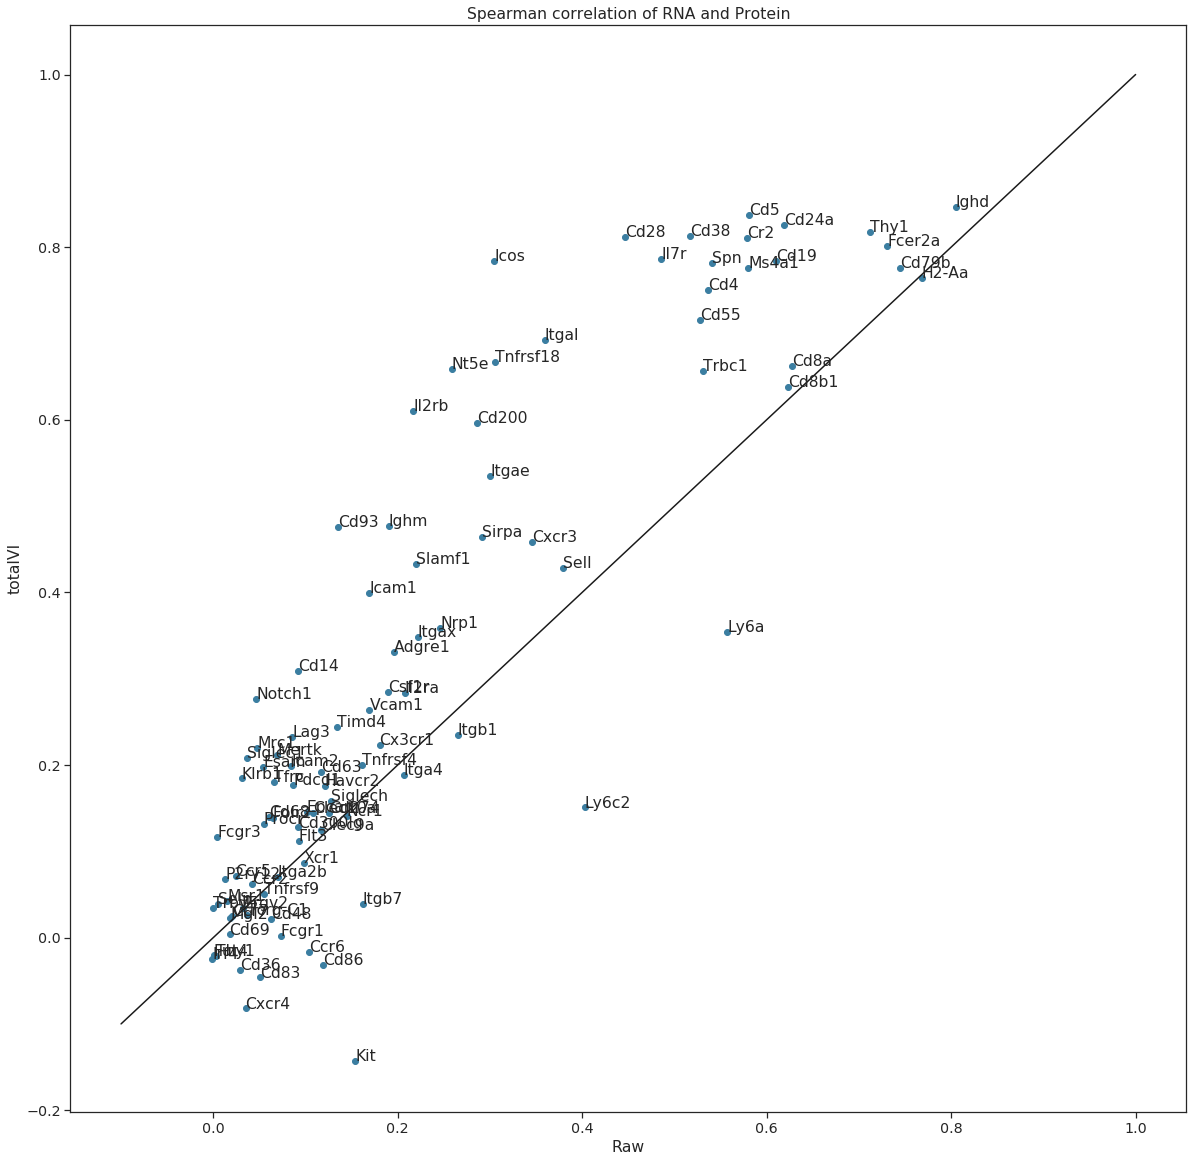

In [56]:
# Plot Spearman correlation
# With RNA names    
plt.figure(figsize = (20, 20))
plt.scatter(x = corr_df_spearman_noiso[["raw_correlation"]], y = corr_df_spearman_noiso[["totalVI_correlation"]])
plt.plot([-.1,1],[-.1,1], "k")
plt.title("Spearman correlation of RNA and Protein")
plt.xlabel("Raw")
plt.ylabel("totalVI")
for x, y, s in zip(corr_df_spearman_noiso[["raw_correlation"]].values, corr_df_spearman_noiso[["totalVI_correlation"]].values, corr_df_spearman_noiso[["RNA"]].values):
    plt.text(x[0], y[0], s[0])

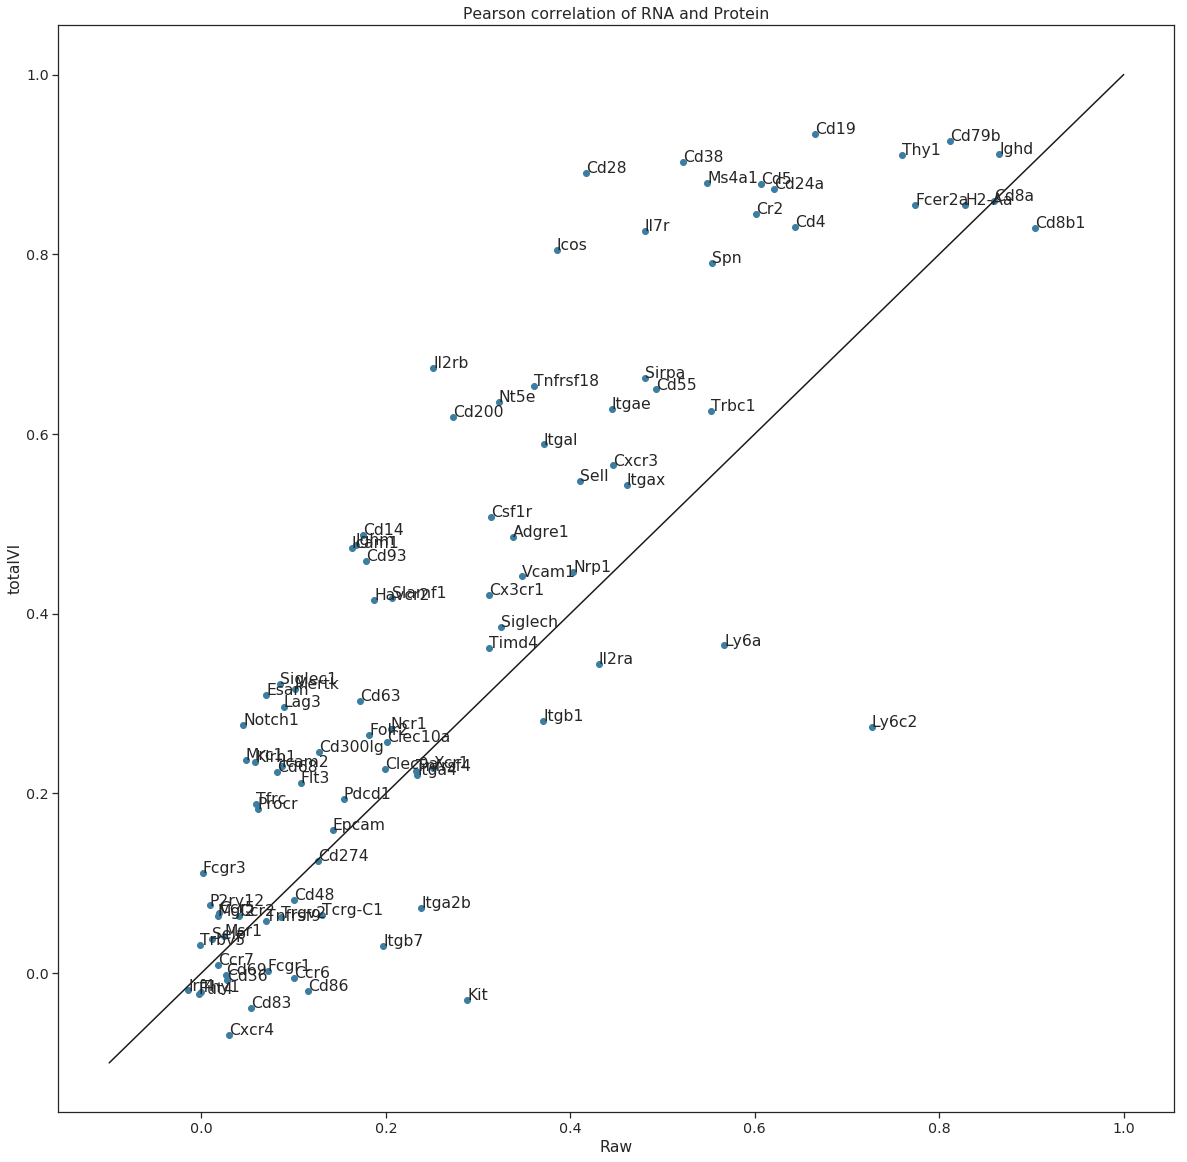

In [58]:
# Plot Pearson
# With RNA names    
plt.figure(figsize = (20, 20))
plt.scatter(x = corr_df_pearson_noiso[["raw_correlation"]], y = corr_df_pearson_noiso[["totalVI_correlation"]])
plt.plot([-.1,1],[-.1,1], "k")
plt.title("Pearson correlation of RNA and Protein")
plt.xlabel("Raw")
plt.ylabel("totalVI")
for x, y, s in zip(corr_df_pearson_noiso[["raw_correlation"]].values, corr_df_pearson_noiso[["totalVI_correlation"]].values, corr_df_pearson_noiso[["RNA"]].values):
    plt.text(x[0], y[0], s[0])

### Plot RNA-protein correlations for totalVI vs raw

In [59]:
corr_df_spearman_noiso

,RNA,Protein,totalVI_correlation,raw_correlation
0,Icam2,ADT_CD102_A0104,0.198742,0.084558
1,Itgae,ADT_CD103_A0201,0.534466,0.300348
2,Vcam1,ADT_CD106_A0226,0.263311,0.169306
3,Csf1r,ADT_CD115(CSF-1R)_A0105,0.284771,0.189167
4,Kit,ADT_CD117(c-Kit)_A0012,-0.142398,0.154067
...,...,...,...,...
96,Tcrg-C1,ADT_TCRr-d_A0121,0.025822,0.036817
97,Timd4,ADT_Tim-4_A0567,0.244142,0.134203
98,Xcr1,ADT_XCR1_A0568,0.086589,0.098313
99,P2ry12,ADT_anti-P2RY12_A0415,0.067751,0.013188


In [60]:
# Color each point by raw protein counts, RNA, pr(fore)
#raw_data = np.concatenate((adata.X, np.log1p(adata.obsm["protein_expression"])), axis = 1) # concat genes, proteins
mean_raw = (np.mean(raw_data, axis = 0))

In [61]:
mean_foreground = np.mean(protein_foreground_prob, axis = 0)

In [62]:
# Extract the mean protein values for the plotted proteins
protein_means = np.asarray([mean_raw[np.where(gene_protein_names == protein)][0] for protein in corr_df_spearman_noiso[["Protein"]].values.ravel()])

In [63]:
rna_means = np.asarray([mean_raw[np.where(gene_protein_names == protein)][0] for protein in corr_df_spearman_noiso[["RNA"]].values.ravel()])

In [64]:
# foreground
foreground_means = np.asarray([mean_foreground[np.where(dataset.protein_names == protein)[0][0]] for protein in corr_df_spearman_noiso[["Protein"]].values.ravel()])

In [65]:
len(foreground_means)

97

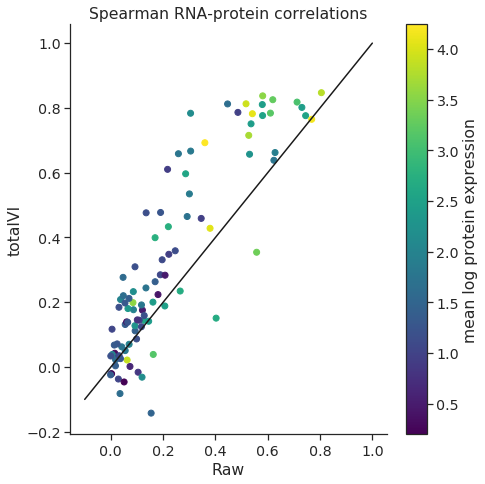

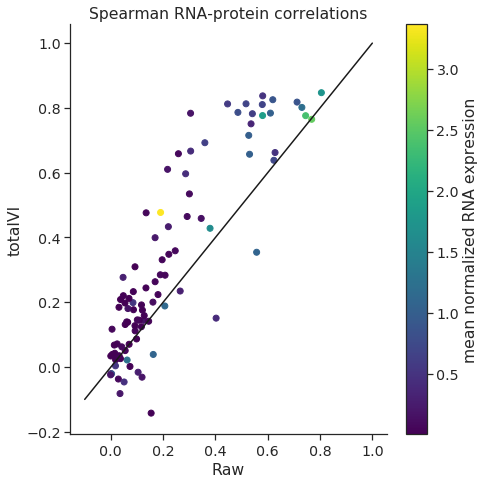

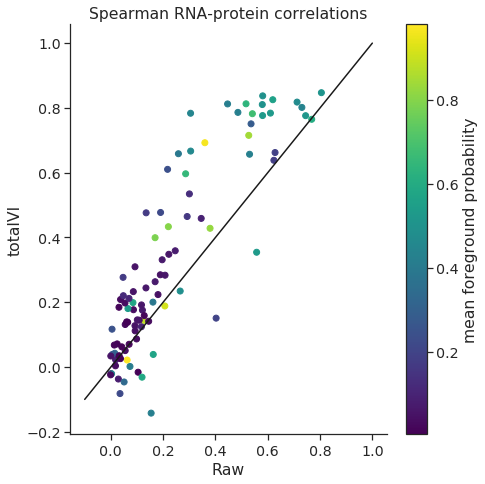

In [68]:
# Plot Spearman correlation
colors_to_plot = [protein_means, rna_means, foreground_means]
labels = ["mean log protein expression", "mean normalized RNA expression", "mean foreground probability"]
filenames = ["protein", "rna", "foreground"]

for i in range(len(colors_to_plot)):
    plt.figure(figsize = (7,7))
    a = plt.scatter(x = corr_df_spearman_noiso[["raw_correlation"]].values.ravel(), y = corr_df_spearman_noiso[["totalVI_correlation"]].values.ravel(),
               rasterized=True,
               c = colors_to_plot[i], # protein_means
               cmap = plt.cm.viridis, # "viridis", #
               )

    sns.despine()
    plt.plot([-.1,1],[-.1,1], "k")
    plt.title("Spearman RNA-protein correlations")
    plt.xlabel("Raw")
    plt.ylabel("totalVI")
    # for x, y, s in zip(corr_df_spearman_noiso[["raw_correlation"]].values, corr_df_spearman_noiso[["totalVI_correlation"]].values, corr_df_spearman_noiso[["RNA"]].values):
    #     plt.text(x[0], y[0], s[0])
    cbar = plt.colorbar(a)
    cbar.set_label(labels[i])
    plt.tight_layout()


    plt.savefig("figures/spearman_RNAprot_%s_log.pdf" %filenames[i], bbox_inches="tight", dpi = DPI)

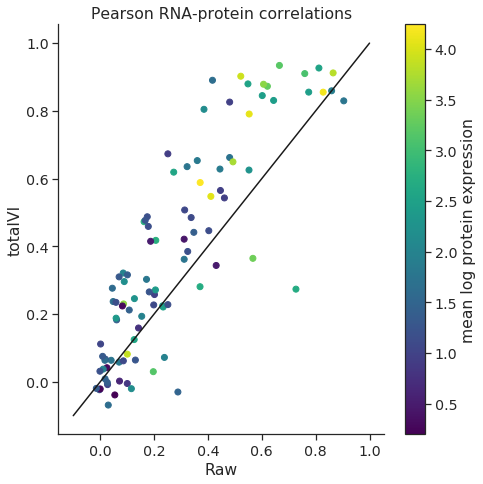

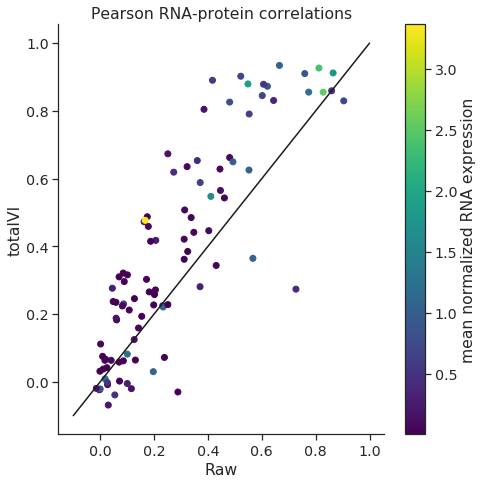

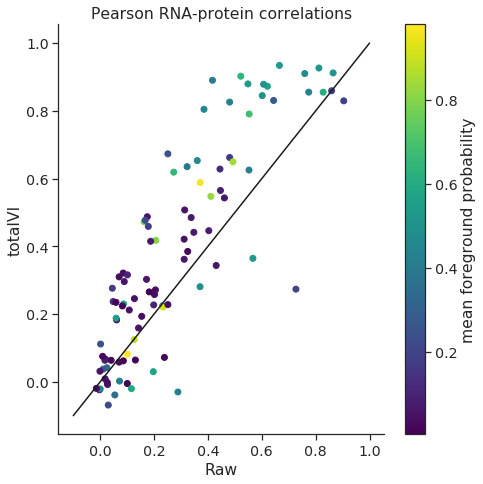

In [69]:
# Plot Pearson correlation
colors_to_plot = [protein_means, rna_means, foreground_means]
labels = ["mean log protein expression", "mean normalized RNA expression", "mean foreground probability"]
filenames = ["protein", "rna", "foreground"]


for i in range(len(colors_to_plot)):
    plt.figure(figsize = (7,7))
    a = plt.scatter(x = corr_df_pearson_noiso[["raw_correlation"]].values.ravel(), y = corr_df_pearson_noiso[["totalVI_correlation"]].values.ravel(),
               rasterized=True,
               c = colors_to_plot[i], # protein_means
               cmap = plt.cm.viridis, # "viridis", #
               )

    sns.despine()
    plt.plot([-.1,1],[-.1,1], "k")
    plt.title("Pearson RNA-protein correlations")
    plt.xlabel("Raw")
    plt.ylabel("totalVI")
    # for x, y, s in zip(corr_df_spearman_noiso[["raw_correlation"]].values, corr_df_spearman_noiso[["totalVI_correlation"]].values, corr_df_spearman_noiso[["RNA"]].values):
    #     plt.text(x[0], y[0], s[0])
    cbar = plt.colorbar(a)
    cbar.set_label(labels[i])
    plt.tight_layout()

#plt.savefig("figures/pearson_RNAprot.pdf", bbox_inches="tight", dpi = DPI)
    plt.savefig("figures/pearson_RNAprot_%s_log.pdf" %filenames[i], bbox_inches="tight", dpi = DPI)